In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import os
os.chdir('/content/drive/MyDrive/Extreme-Whether-Event-Prediction')

# Pre-2004 Wildfire Prediction Using LSTM
- We will use LSTM to predict the **number of wildfires per day** and the **average fire size** in California. The model will use environmental data such as **temperature** and **precipitation** to improve accuracy.

In [87]:
df = pd.read_csv('pre_2004_data.csv')
df

,DiscoveryDate,DiscoveryDayOfYear,DiscoveryTime,ContainmentDate,ContainmentDayOfYear,ContainmentTime,FireSize,FireSizeClass,Latitude,Longitude,CauseClassification,GeneralCause,MinTemperature,MaxTemperature,AvgTemperature,Precipitation,Snowfall
0,1992-01-01,1,01:30,1992-01-01,1.0,02:10,0.1,A,38.205000,-120.335000,Natural,Natural,3.89,13.89,8.89,0.00,0.0
1,1992-01-01,1,13:30,1992-01-01,1.0,17:00,5.0,B,33.166700,-116.634200,Human,Debris and open burning,-1.67,12.78,5.56,0.00,0.0
2,1992-01-01,1,14:37,1992-01-01,1.0,15:07,0.2,A,33.663889,-116.171944,Human,Misuse of fire by a minor,-1.67,12.78,5.56,0.00,0.0
3,1992-01-02,2,14:37,1992-01-02,2.0,15:07,0.2,A,33.030000,-116.831944,Human,Missing data/not specified/undetermined,-1.11,12.22,5.56,0.00,0.0
4,1992-01-02,2,14:37,1992-01-02,2.0,15:17,0.5,B,33.896111,-116.990000,Human,Missing data/not specified/undetermined,-1.11,12.22,5.56,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96831,2003-12-29,363,07:41,2003-12-29,363.0,08:00,0.1,A,34.140000,-117.150000,Human,Power generation/transmission/distribution,-1.67,9.44,3.89,0.00,0.0
96832,2003-12-29,363,21:40,2003-12-29,363.0,22:30,0.1,A,34.381944,-118.097222,Human,Arson/incendiarism,-1.67,9.44,3.89,0.00,0.0
96833,2003-12-31,365,15:58,2003-12-31,365.0,16:31,0.2,A,33.968056,-117.515000,Human,Equipment and vehicle use,0.56,12.78,6.67,0.00,0.0
96834,2003-12-31,365,16:53,2003-12-31,365.0,17:02,0.1,A,38.185000,-120.371389,Human,Debris and open burning,3.89,11.11,7.50,0.51,0.0


In [88]:
# Select relevant columns for  prediction
df_selected = df[['DiscoveryDate', 'FireSize', 'MaxTemperature', 'Precipitation']]
df_selected.head()

,DiscoveryDate,FireSize,MaxTemperature,Precipitation
0,1992-01-01,0.1,13.89,0.0
1,1992-01-01,5.0,12.78,0.0
2,1992-01-01,0.2,12.78,0.0
3,1992-01-02,0.2,12.22,0.0
4,1992-01-02,0.5,12.22,0.0


### Plot FireSize, MaxTemperature, and Precipitation

In [89]:
df_selected = df_selected.copy()
df_selected['DiscoveryDate'] = pd.to_datetime(df_selected['DiscoveryDate'], errors='coerce')

df_selected.set_index('DiscoveryDate', inplace=True)

Text(0, 0.5, 'Fire Size')

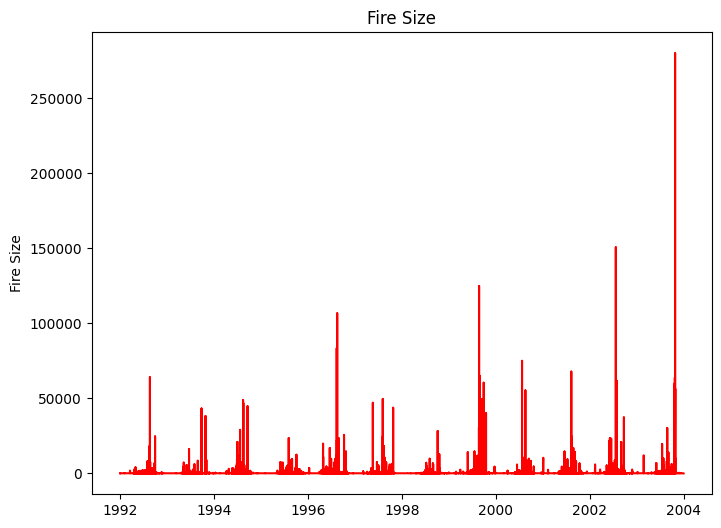

In [90]:
# Fire Size
plt.figure(figsize=(8, 6))
plt.plot(df_selected.index, df_selected['FireSize'], label='Fire Size', color='red')
plt.title('Fire Size')
plt.ylabel('Fire Size')

Text(0, 0.5, 'Max Temperature (°C)')

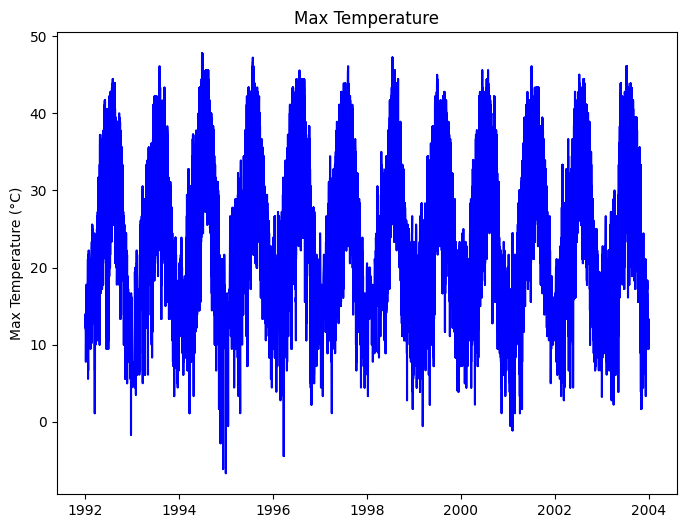

In [91]:
# Max Temperature
plt.figure(figsize=(8, 6))
plt.plot(df_selected.index, df_selected['MaxTemperature'], label='Max Temperature', color='blue')
plt.title('Max Temperature')
plt.ylabel('Max Temperature (°C)')

## Number of Wildfires per Day Prediction

In [92]:
# Group by DiscoveryDate and count the number of fires, average environmental factors
df_aggregated = df_selected.groupby('DiscoveryDate').agg({
    'FireSize': 'count',
    'MaxTemperature': 'mean',
    'Precipitation': 'mean',
}).rename(columns={'FireSize': 'NumberOfFires'})

df_aggregated

,NumberOfFires,MaxTemperature,Precipitation
DiscoveryDate,,,
1992-01-01,3,13.150000,0.00
1992-01-02,3,12.220000,0.00
1992-01-03,1,13.890000,0.00
1992-01-04,2,12.220000,0.00
1992-01-06,1,11.670000,1.78
...,...,...,...
2003-12-24,1,13.330000,21.08
2003-12-27,1,13.330000,0.00
2003-12-28,3,10.736667,0.00


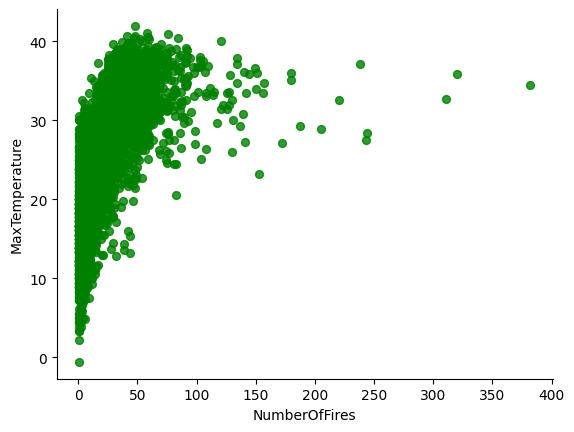

In [93]:
# NumberOfFires vs MaxTemperature
df_aggregated.plot(kind='scatter', x='NumberOfFires', y='MaxTemperature', color="green", s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Set the Frequency to Daily and Fill Missing Data

In [94]:
# Set the frequency of the dataframe to daily
df_aggregated = df_aggregated.asfreq('D')

# Fill missing NumberOfFires with 0
df_aggregated['NumberOfFires'].fillna(0, inplace=True)

# Handle missing environmental variables with interpolation
df_aggregated.loc[:, ['MaxTemperature', 'Precipitation']] = df_aggregated.loc[:, ['MaxTemperature', 'Precipitation']].interpolate(method='linear')

df_aggregated

<ipython-input-94-97d83340d0b4>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_aggregated['NumberOfFires'].fillna(0, inplace=True)


,NumberOfFires,MaxTemperature,Precipitation
DiscoveryDate,,,
1992-01-01,3.0,13.150000,0.000
1992-01-02,3.0,12.220000,0.000
1992-01-03,1.0,13.890000,0.000
1992-01-04,2.0,12.220000,0.000
1992-01-05,0.0,11.945000,0.890
...,...,...,...
2003-12-27,1.0,13.330000,0.000
2003-12-28,3.0,10.736667,0.000
2003-12-29,3.0,9.440000,0.000


(array([ 7670.,  8035.,  8401.,  8766.,  9131.,  9496.,  9862., 10227.,
        10592., 10957., 11323., 11688., 12053., 12418.]),
 [Text(7670.0, 0, '1991'),
  Text(8035.0, 0, '1992'),
  Text(8401.0, 0, '1993'),
  Text(8766.0, 0, '1994'),
  Text(9131.0, 0, '1995'),
  Text(9496.0, 0, '1996'),
  Text(9862.0, 0, '1997'),
  Text(10227.0, 0, '1998'),
  Text(10592.0, 0, '1999'),
  Text(10957.0, 0, '2000'),
  Text(11323.0, 0, '2001'),
  Text(11688.0, 0, '2002'),
  Text(12053.0, 0, '2003'),
  Text(12418.0, 0, '2004')])

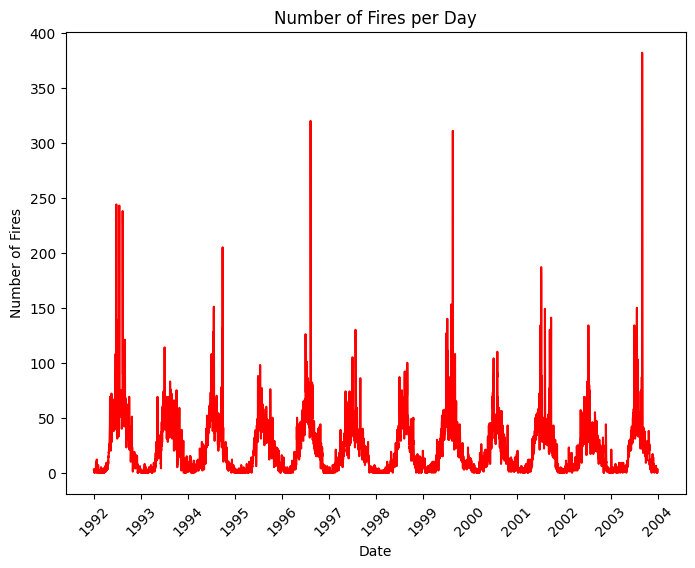

In [95]:
# Plot Number of Fires per day
plt.figure(figsize=(8, 6))
plt.plot(df_aggregated.index, df_aggregated['NumberOfFires'], label='Number of Fires', color='red')
plt.title('Number of Fires per Day')
plt.ylabel('Number of Fires')
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

(array([ 7670.,  8035.,  8401.,  8766.,  9131.,  9496.,  9862., 10227.,
        10592., 10957., 11323., 11688., 12053., 12418.]),
 [Text(7670.0, 0, '1991'),
  Text(8035.0, 0, '1992'),
  Text(8401.0, 0, '1993'),
  Text(8766.0, 0, '1994'),
  Text(9131.0, 0, '1995'),
  Text(9496.0, 0, '1996'),
  Text(9862.0, 0, '1997'),
  Text(10227.0, 0, '1998'),
  Text(10592.0, 0, '1999'),
  Text(10957.0, 0, '2000'),
  Text(11323.0, 0, '2001'),
  Text(11688.0, 0, '2002'),
  Text(12053.0, 0, '2003'),
  Text(12418.0, 0, '2004')])

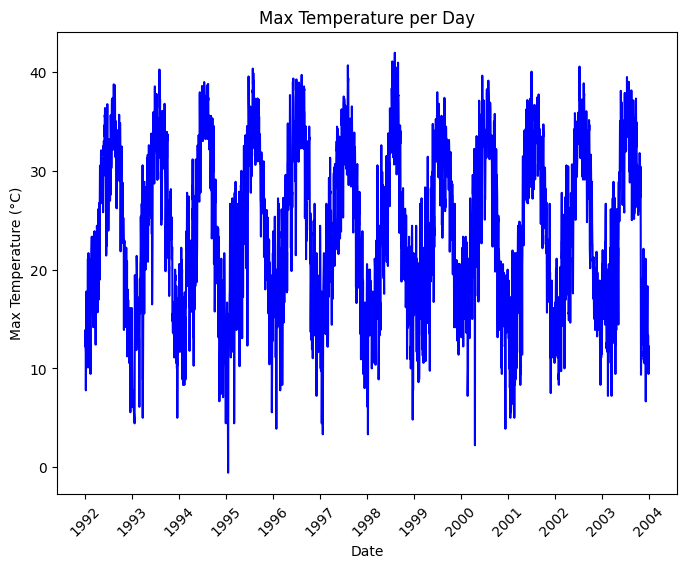

In [96]:
# Plot Max Temperature per day
plt.figure(figsize=(8, 6))
plt.plot(df_aggregated.index, df_aggregated['MaxTemperature'], label='Max Temperature', color='blue')
plt.title('Max Temperature per Day')
plt.ylabel('Max Temperature (°C)')
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

In [227]:
df_aggregated

,NumberOfFires,MaxTemperature,Precipitation
DiscoveryDate,,,
1992-01-01,3.0,13.150000,0.000
1992-01-02,3.0,12.220000,0.000
1992-01-03,1.0,13.890000,0.000
1992-01-04,2.0,12.220000,0.000
1992-01-05,0.0,11.945000,0.890
...,...,...,...
2003-12-27,1.0,13.330000,0.000
2003-12-28,3.0,10.736667,0.000
2003-12-29,3.0,9.440000,0.000


In [228]:
# Split the data
X = df_aggregated[['MaxTemperature', 'NumberOfFires', 'Precipitation']].values
y = df_aggregated['NumberOfFires'].values

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 80% of train for training, 20% of train for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

X_train_split.shape, X_val_split.shape, X_test.shape, y_train_split.shape, y_val_split.shape, y_test.shape

((2804, 3), (702, 3), (877, 3), (2804,), (702,), (877,))

In [229]:
# Convert `X_train_split` back to a DataFrame
df_train_split = pd.DataFrame(X_train_split, columns=['MaxTemperature', 'NumberOfFires', 'Precipitation'])
df_train_split['y'] = y_train_split
df_train_split

,MaxTemperature,NumberOfFires,Precipitation,y
0,13.150000,3.0,0.00,3.0
1,12.220000,3.0,0.00,3.0
2,13.890000,1.0,0.00,1.0
3,12.220000,2.0,0.00,2.0
4,11.945000,0.0,0.89,0.0
...,...,...,...,...
2799,25.922759,29.0,0.00,29.0
2800,27.155152,33.0,0.00,33.0
2801,26.296667,21.0,0.00,21.0
2802,27.082500,24.0,0.00,24.0


In [230]:
# Identify spikes in the training data
spike_threshold = 100
spikes_train = df_train_split[df_train_split['NumberOfFires'] > spike_threshold]

# Current spike percentage
current_spike_percentage = (len(spikes_train) / len(df_train_split)) * 100
desired_spike_percentage = 15

# Duplication factor
duplication_factor = int((desired_spike_percentage / current_spike_percentage) - 1)
duplication_factor

11

In [231]:
# Duplicate each spike by duplication factor
duplicated_spikes = spikes_train.loc[spikes_train.index.repeat(duplication_factor - 1)]

df_train_split_augmented = pd.concat([df_train_split, duplicated_spikes])
df_train_split_augmented = df_train_split_augmented.sort_index()

df_train_split_augmented

,MaxTemperature,NumberOfFires,Precipitation,y
0,13.150000,3.0,0.00,3.0
1,12.220000,3.0,0.00,3.0
2,13.890000,1.0,0.00,1.0
3,12.220000,2.0,0.00,2.0
4,11.945000,0.0,0.89,0.0
...,...,...,...,...
2799,25.922759,29.0,0.00,29.0
2800,27.155152,33.0,0.00,33.0
2801,26.296667,21.0,0.00,21.0
2802,27.082500,24.0,0.00,24.0


In [232]:
X_train_augmented = df_train_split_augmented[['MaxTemperature', 'NumberOfFires', 'Precipitation']].values
y_train_augmented = df_train_split_augmented['y'].values

In [233]:
# Normalize The Data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler on the augmented training set
X_train_scaled = scaler_X.fit_transform(X_train_augmented)
X_val_scaled = scaler_X.transform(X_val_split)
X_test_scaled = scaler_X.transform(X_test)

# Normalize the target variable
y_train_scaled = scaler_y.fit_transform(y_train_augmented.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val_split.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

X_train_scaled[:10], y_train_scaled[:10]

(array([[0.3224444 , 0.009375  , 0.        ],
        [0.3005718 , 0.009375  , 0.        ],
        [0.3398484 , 0.003125  , 0.        ],
        [0.3005718 , 0.00625   , 0.        ],
        [0.2941041 , 0.        , 0.00832281],
        [0.2876364 , 0.003125  , 0.01664563],
        [0.1961478 , 0.003125  , 0.03329125],
        [0.244048  , 0.        , 0.02219417],
        [0.2919482 , 0.        , 0.01109708],
        [0.3398484 , 0.00625   , 0.        ]]),
 array([[0.009375],
        [0.009375],
        [0.003125],
        [0.00625 ],
        [0.      ],
        [0.003125],
        [0.003125],
        [0.      ],
        [0.      ],
        [0.00625 ]]))

In [234]:
# Create Sequences function for time series
def create_sequences(data, target, sequence_length=7):
    X_seq = []
    y_seq = []

    for i in range(len(data) - sequence_length):
        X_seq.append(data[i:i+sequence_length])
        y_seq.append(target[i + sequence_length])

    return np.array(X_seq), np.array(y_seq)

seq_len = 7

# Sequences for the training set
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length=seq_len)

# Sequences for the validation set
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, sequence_length=seq_len)

# Sequences for the test set
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, sequence_length=seq_len)

X_train_seq.shape, X_val_seq.shape, X_test_seq.shape, y_train_seq.shape, y_val_seq.shape, y_test_seq.shape

((3127, 7, 3), (695, 7, 3), (870, 7, 3), (3127, 1), (695, 1), (870, 1))

In [235]:
# Reshape Input: [samples, timesteps, features]
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2]))

# Reshape for the validation set
X_val_seq = X_val_seq.reshape((X_val_seq.shape[0], X_val_seq.shape[1], X_val_seq.shape[2]))

# Reshape for the test set
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2]))

X_train_seq.shape, X_val_seq.shape, X_test_seq.shape

((3127, 7, 3), (695, 7, 3), (870, 7, 3))

In [236]:
# Build the LSTM Model
model = Sequential()

# First LSTM layer with dropout
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer with dropout
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))

# Output layer (single value: Number of Wildfires)
model.add(Dense(1))

# Use Adam Optimizer with lower learning rate
optimizer = Adam(learning_rate=0.001)

# Loss function for weighted MSE
def weighted_mse(y_true, y_pred):
    weights = tf.where(y_true < 50, 2.0, 1.0)
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))

# Compile the model
model.compile(optimizer=optimizer, loss=weighted_mse)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                       │ (None, 7, 100)              │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 7, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,101 (476.96 KB)

 Trainable params: 122,101 (476.96 KB)

 Non-trainable params: 0 (0.00 B)

In [237]:
# Train the LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq,
    y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0311 - val_loss: 0.0032
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0151 - val_loss: 0.0030
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0113 - val_loss: 0.0032
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0089 - val_loss: 0.0042
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0108 - val_loss: 0.0030
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0086 - val_loss: 0.0036
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0107 - val_loss: 0.0028
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0073 - val_loss: 0.0027
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0085 - val_loss: 0.0028
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0070 - val_loss: 0.0025
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step

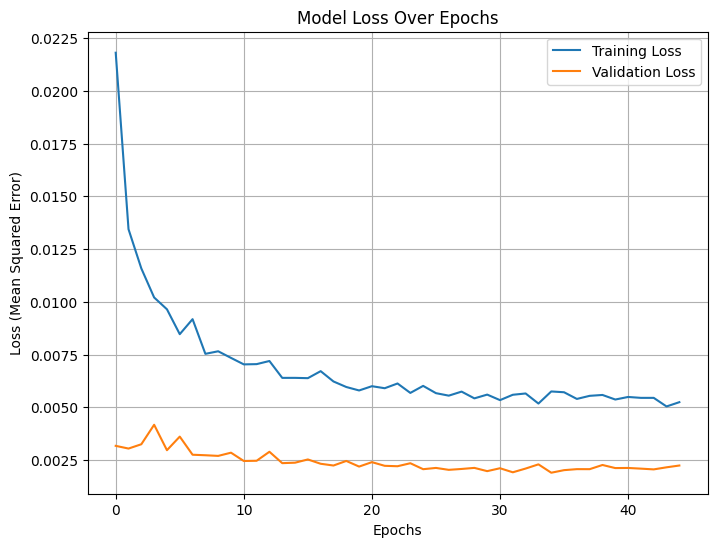

In [238]:
# Plot Training and Validation Loss
def plot_training_history(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history)

In [239]:
# Evaluate Model on Test Data
y_pred = model.predict(X_test_seq)

# Rescale predictions back to original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred)

# Rescale the test target back to original scale
y_test_rescaled = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

# Calculate the Root Mean Squared Error
rmse = mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False)
rmse

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


18.61789430468956

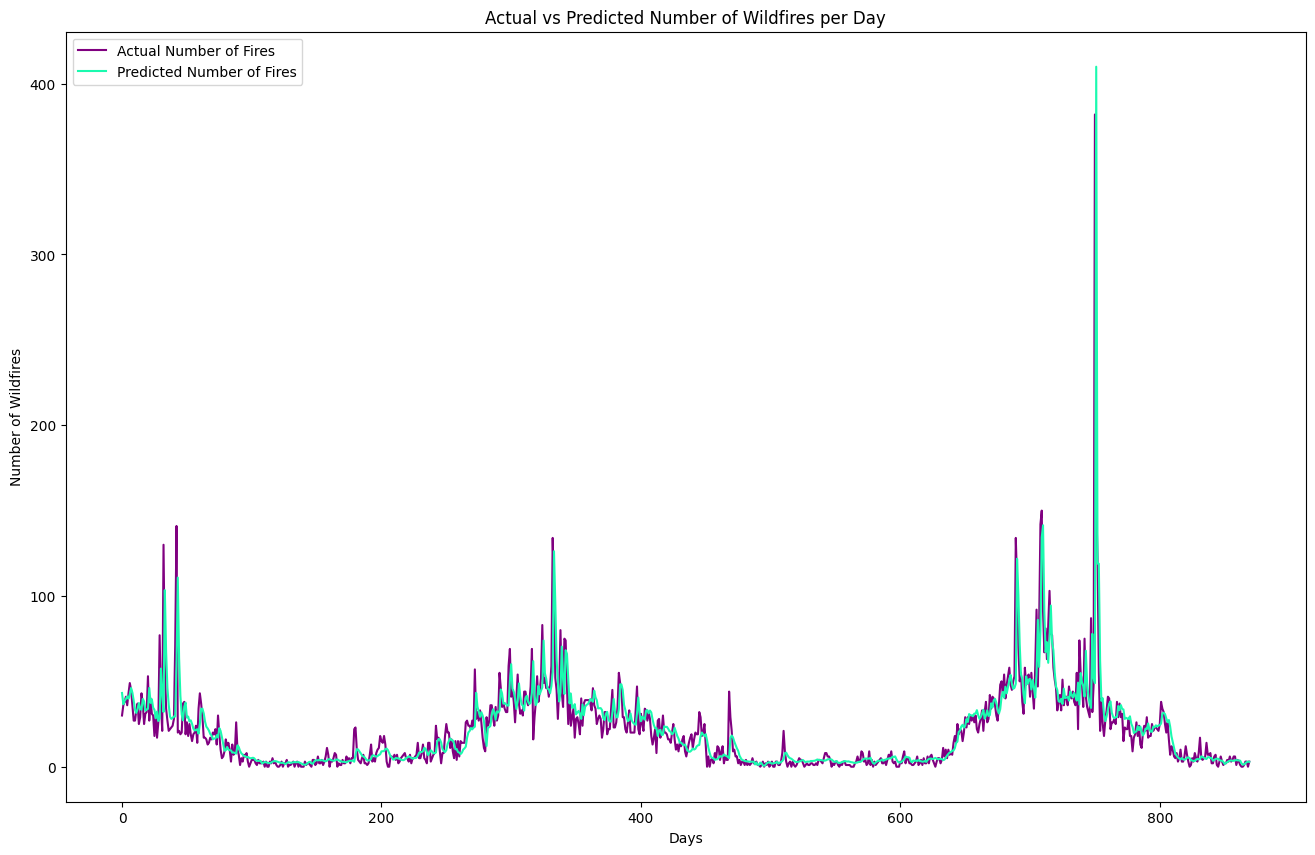

In [262]:
# Plot the actual vs predicted values
plt.figure(figsize=(16, 10))
plt.plot(y_test_rescaled, label='Actual Number of Fires', color='purple')
plt.plot(y_pred_rescaled, label='Predicted Number of Fires', color='#1afaaf')
plt.title('Actual vs Predicted Number of Wildfires per Day')
plt.xlabel('Days')
plt.ylabel('Number of Wildfires')
plt.legend()
plt.show()

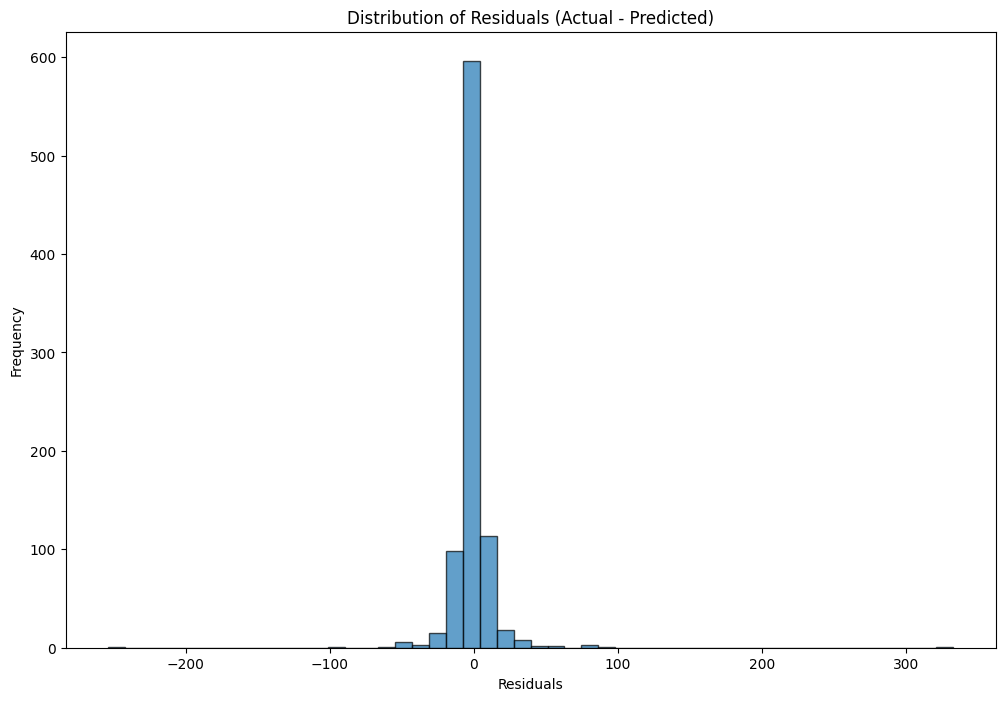

In [241]:
# Calculate residuals (errors)
residuals = y_test_rescaled - y_pred_rescaled

# Plot the residuals
plt.figure(figsize=(12, 8))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Residuals (Actual - Predicted)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [242]:
# Predictions for training set
y_train_pred = model.predict(X_train_seq)

# Predictions for validation set
y_val_pred = model.predict(X_val_seq)

# Predictions for test set
y_test_pred = model.predict(X_test_seq)

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [243]:
# Inverse transform the predictions and the actual data
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_val_pred_rescaled = scaler_y.inverse_transform(y_val_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)

# Inverse transform the actual values
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_val_actual_rescaled = scaler_y.inverse_transform(y_val_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

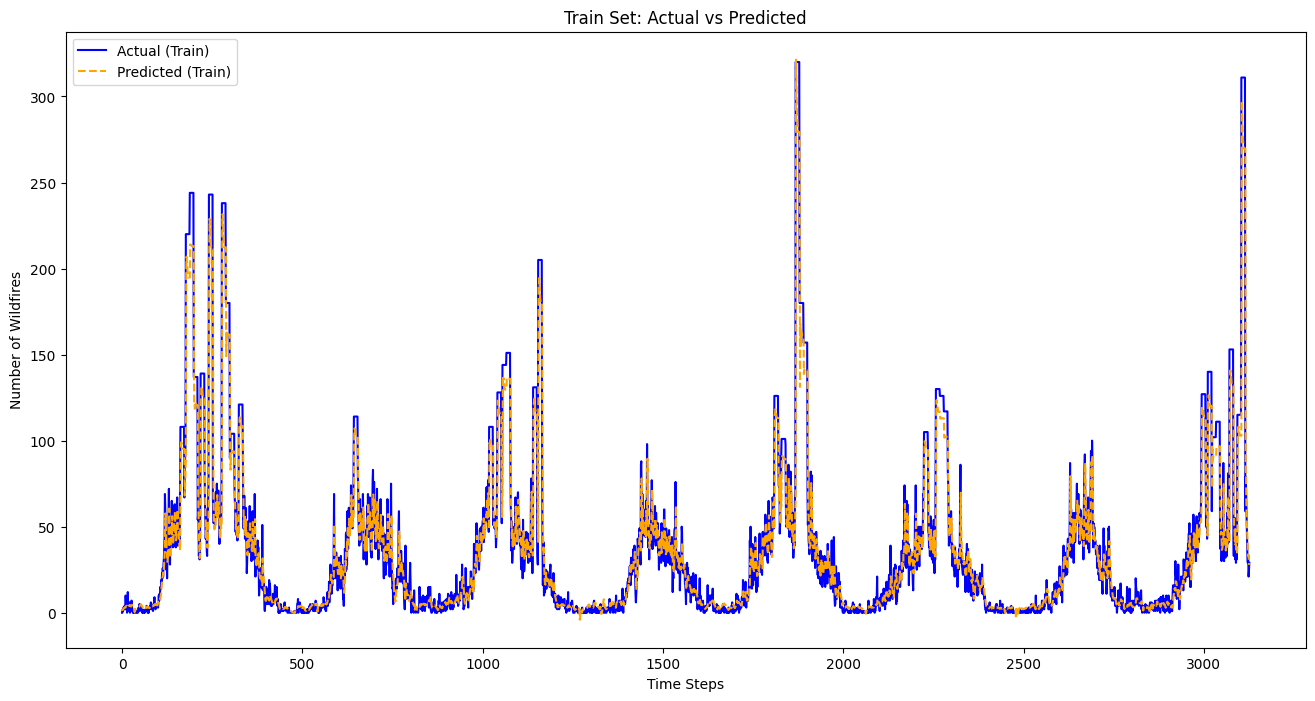

In [249]:
# Plot training set
plt.figure(figsize=(16, 8))

plt.plot(range(len(y_train_actual_rescaled)), y_train_actual_rescaled, label='Actual (Train)', color='blue')
plt.plot(range(len(y_train_pred_rescaled)), y_train_pred_rescaled, label='Predicted (Train)', linestyle='--', color='orange')
plt.title('Train Set: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Number of Wildfires')
plt.legend()
plt.show()

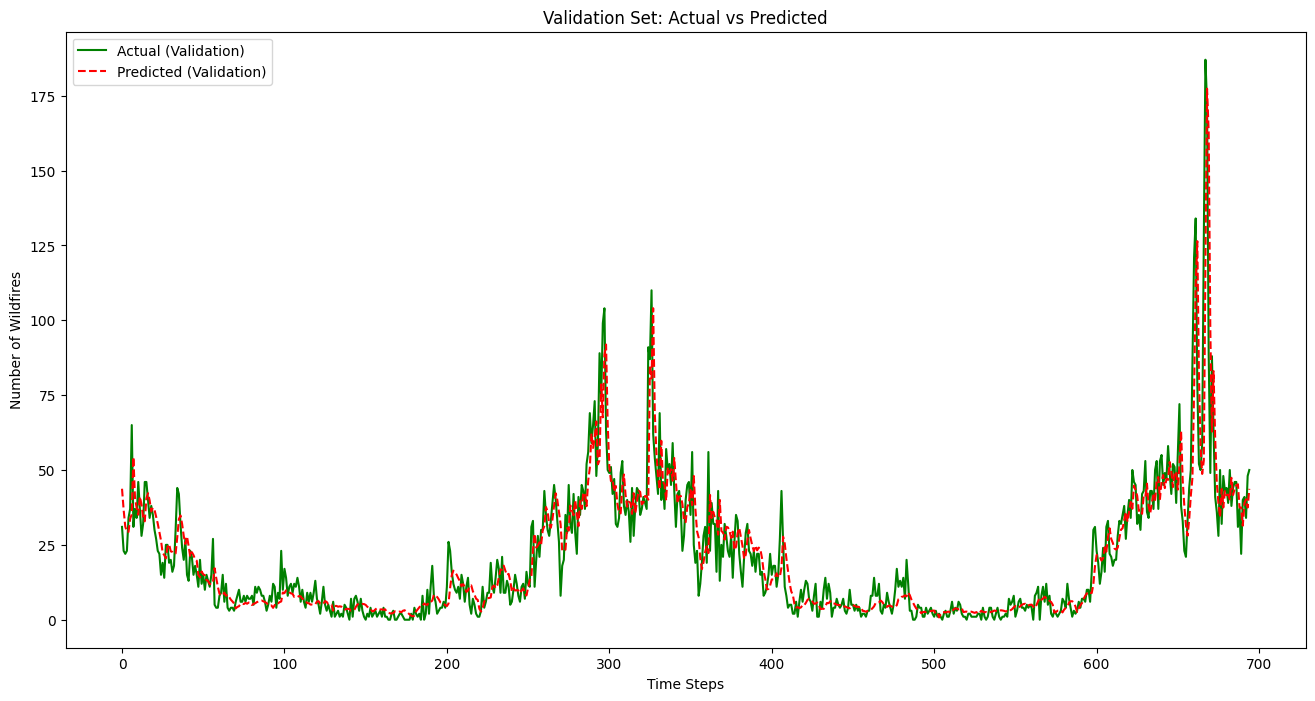

In [250]:
# Plot validation set
plt.figure(figsize=(16, 8))

plt.plot(range(len(y_val_actual_rescaled)), y_val_actual_rescaled, label='Actual (Validation)', color='green')
plt.plot(range(len(y_val_pred_rescaled)), y_val_pred_rescaled, label='Predicted (Validation)', linestyle='--', color='red')
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Number of Wildfires')
plt.legend()

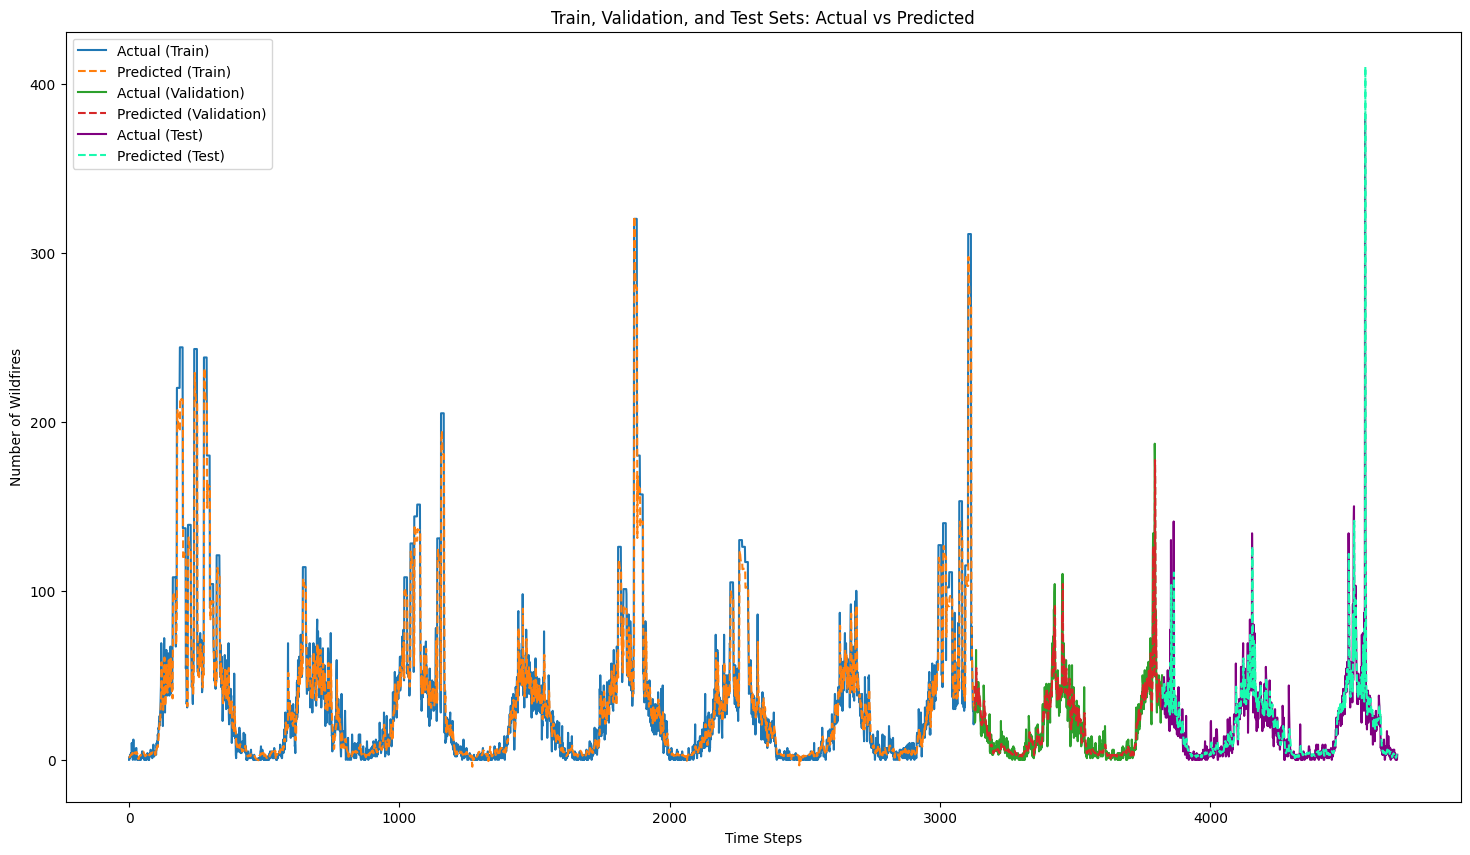

In [261]:
plt.figure(figsize=(18, 10))

# Plot training set
plt.plot(range(len(y_train_actual_rescaled)), y_train_actual_rescaled, label='Actual (Train)')
plt.plot(range(len(y_train_pred_rescaled)), y_train_pred_rescaled, label='Predicted (Train)', linestyle='--')

# Plot validation set
plt.plot(range(len(y_train_actual_rescaled), len(y_train_actual_rescaled) + len(y_val_actual_rescaled)), y_val_actual_rescaled, label='Actual (Validation)')
plt.plot(range(len(y_train_pred_rescaled), len(y_train_pred_rescaled) + len(y_val_pred_rescaled)), y_val_pred_rescaled, label='Predicted (Validation)', linestyle='--')

# Plot test set
plt.plot(range(len(y_train_actual_rescaled) + len(y_val_actual_rescaled), len(y_train_actual_rescaled) + len(y_val_actual_rescaled) + len(y_test_actual_rescaled)), y_test_actual_rescaled, label='Actual (Test)', color="purple")
plt.plot(range(len(y_train_pred_rescaled) + len(y_val_pred_rescaled), len(y_train_pred_rescaled) + len(y_val_pred_rescaled) + len(y_test_pred_rescaled)), y_test_pred_rescaled, label='Predicted (Test)', linestyle='--', color="#1afaaf")

plt.title('Train, Validation, and Test Sets: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Number of Wildfires')
plt.legend()
plt.show()

In [245]:
# Combine the actual and predicted values for the test set
df_test_predictions = pd.DataFrame({
    'Actual': y_test_actual_rescaled.flatten(),
    'Predicted': y_test_pred_rescaled.flatten()
})

df_test_predictions

,Actual,Predicted
0,30.0,43.190926
1,36.0,36.597530
2,38.0,38.621803
3,41.0,39.691406
4,36.0,41.151508
...,...,...
865,1.0,1.347343
866,3.0,2.053154
867,3.0,2.667820
868,0.0,2.986470
